Accumulating RRCS sums: 100%|██████████| 15048/15048 [00:00<00:00, 27717.13it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


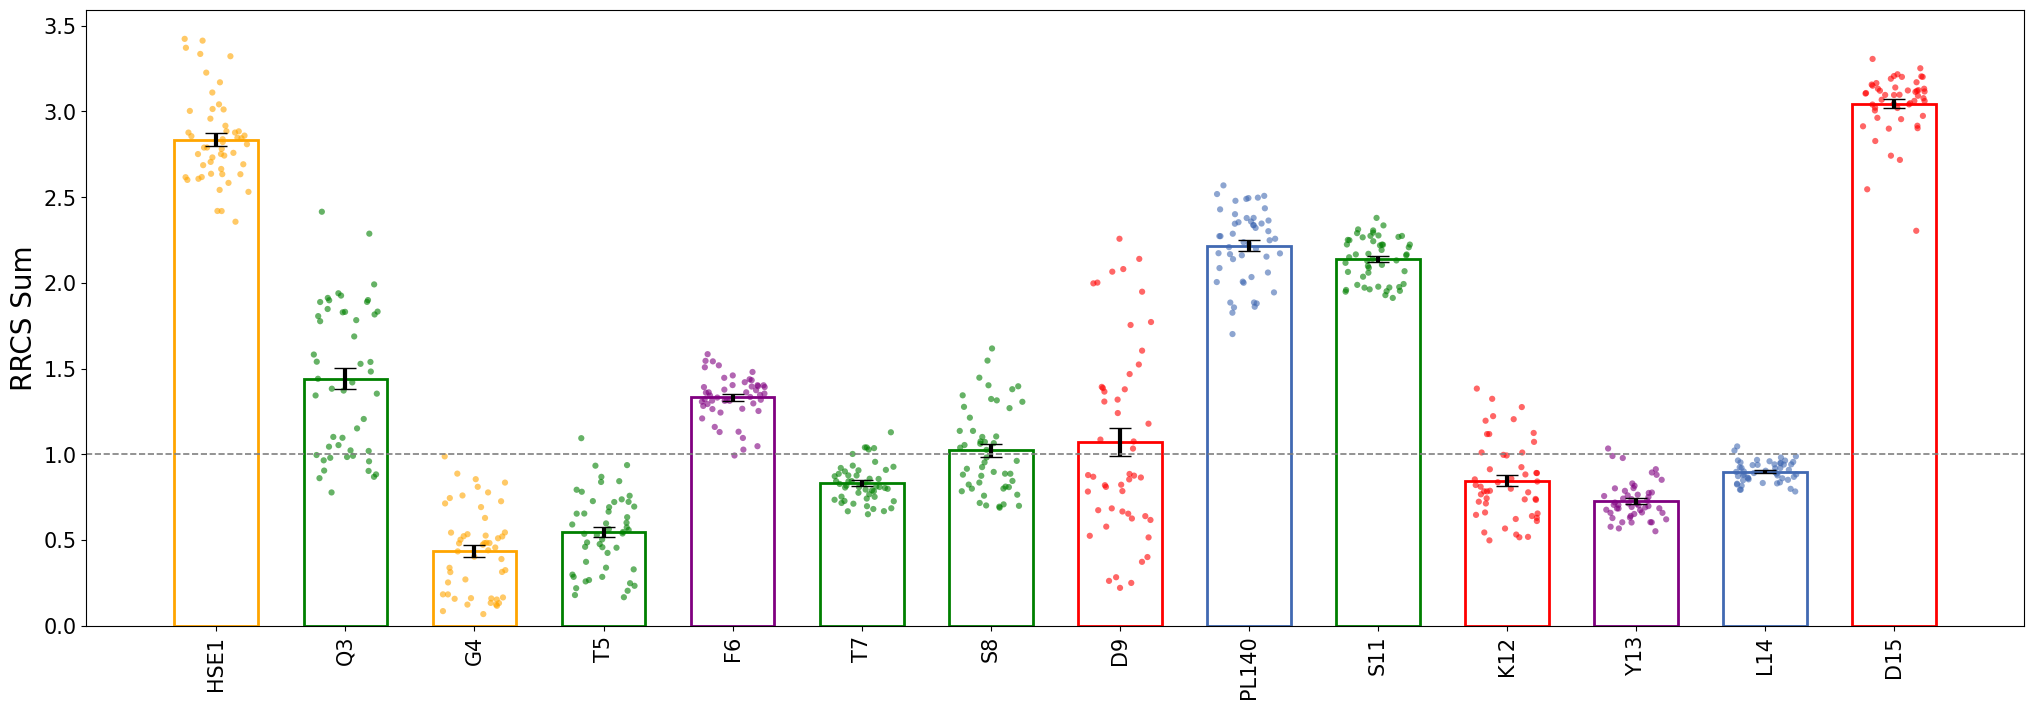

Accumulating RRCS sums by property: 100%|██████████| 15048/15048 [00:00<00:00, 42784.69it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


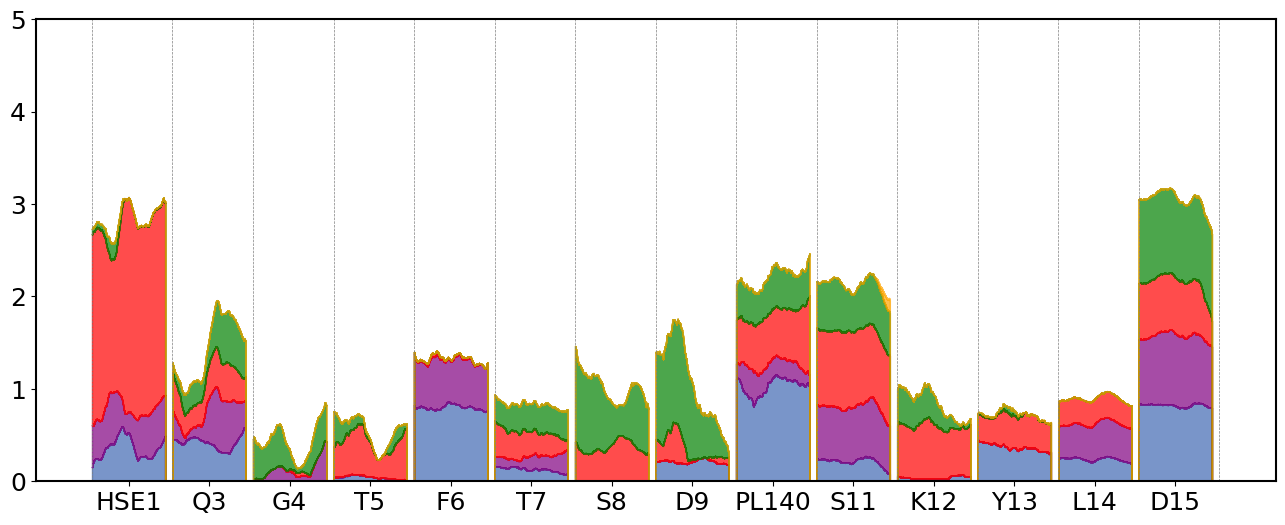

In [14]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import MDAnalysis as mda
import pandas as pd

# File paths
h5_filename = r"C:\Users\Hanoi\Desktop\Bilis\www\www\output_rrcs_A_vs_B\RRCS_Results_RRCS_Normality.h5"
pdb_file = r"C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\data\Bilis_final\ABPL1_noH.pdb"

# Read the HDF5 file
residue_pairs_A, residue_pairs_B, times, rrcs = read_rrcs_normality_h5(h5_filename)

# Load the PDB and select chains
u_pdb = mda.Universe(pdb_file)
proteinA_pdb = u_pdb.select_atoms("(protein or resname PL1 or resname AIB) and chainid A")
proteinB_pdb = u_pdb.select_atoms("protein and chainid B")

# Map residue IDs to residue names (from the PDB)
resid_to_resname_A = {res.resid: res.resname for res in proteinA_pdb.residues}
resid_to_resname_B = {res.resid: res.resname for res in proteinB_pdb.residues}

# =======================
# Define amino acid properties and color mapping
# =======================
amino_acid_properties = {
    'ALA': 'Hydrophobic', 'VAL': 'Hydrophobic', 'LEU': 'Hydrophobic', 'ILE': 'Hydrophobic',
    'PRO': 'Special', 'MET': 'Hydrophobic',
    'PHE': 'Hydrophobic(Aromatic)', 'TYR': 'Hydrophobic(Aromatic)', 'TRP': 'Hydrophobic(Aromatic)',
    'HIS': 'Electrically charged', 'LYS': 'Electrically charged', 'ARG': 'Electrically charged',
    'ASP': 'Electrically charged', 'GLU': 'Electrically charged',
    'ASN': 'Polar uncharged', 'GLN': 'Polar uncharged', 'SER': 'Polar uncharged', 'THR': 'Polar uncharged',
    'CYS': 'Special', 'GLY': 'Special', 'SEC': 'Special', 'UNK': 'Special',
    'PL1': 'Hydrophobic', 'AIB': 'Hydrophobic'
}

property_colors = {
    'Hydrophobic': '#4169B2',               # Royal Blue
    'Hydrophobic(Aromatic)': '#800080',     # Purple
    'Electrically charged': '#FF0000',      # Red
    'Polar uncharged': '#008000',           # Green
    'Special': '#FFA500'                     # Orange
}

def get_amino_acid_property(resname):
    return amino_acid_properties.get(resname.upper(), 'Special')

# =======================
# Map a residue ID to a property (for chain A and chain B)
# =======================
resid_to_property_A = {}
for resid, resname in resid_to_resname_A.items():
    prop = get_amino_acid_property(resname)
    resid_to_property_A[resid] = prop

resid_to_property_B = {}
for resid, resname in resid_to_resname_B.items():
    prop = get_amino_acid_property(resname)
    resid_to_property_B[resid] = prop

# =======================
# Filter the data in the specified time window
# =======================
bt = 500000.0   # 500 ns in ps
et = 1000000.0  # 1000 ns in ps
time_indices = np.where((times >= bt) & (times <= et))[0]
filtered_times = times[time_indices]
filtered_rrcs = rrcs[:, time_indices]

# =======================
# Calculate the total RRCS for each Protein A residue
# =======================
unique_resid_A = np.unique(residue_pairs_A)
rrcs_sum_A_filtered = {resid: np.zeros(len(filtered_times), dtype=np.float32) for resid in unique_resid_A}

for i in tqdm(range(len(residue_pairs_A)), desc="Accumulating RRCS sums"):
    a_resid = residue_pairs_A[i]
    rrcs_sum_A_filtered[a_resid] += filtered_rrcs[i]

# =======================
# Calculate the average RRCS value and standard error for each residue
# =======================
averaged_rrcs_sum_A = {}
averaged_rrcs_values_A = {}
frames_per_average = 100  # Can be adjusted as needed

for resid in unique_resid_A:
    rrcs_sum = rrcs_sum_A_filtered[resid]
    num_complete_averages = len(rrcs_sum) // frames_per_average
    if num_complete_averages == 0:
        print(f"Residue {resid} has less than {frames_per_average} frames.")
        continue
    rrcs_sum_trimmed = rrcs_sum[:num_complete_averages * frames_per_average]
    averaged_rrcs = rrcs_sum_trimmed.reshape(-1, frames_per_average).mean(axis=1)
    averaged_rrcs_sum_A[resid] = averaged_rrcs.mean()
    averaged_rrcs_values_A[resid] = averaged_rrcs

data_for_plot_A = []
for resid in unique_resid_A:
    if resid not in averaged_rrcs_sum_A:
        continue
    mean = averaged_rrcs_sum_A[resid]
    se = np.std(averaged_rrcs_values_A[resid], ddof=1) / np.sqrt(len(averaged_rrcs_values_A[resid]))
    # Convert resid to integer when looking up its name
    resname = resid_to_resname_A.get(int(resid), f"Res{resid}")
    property_A = get_amino_acid_property(resname)
    label = f"{resid}_{resname}"
    data_for_plot_A.append({'Resid': resid, 'Residue': label, 'Mean': mean, 'SE': se, 'Property': property_A, 'Values': averaged_rrcs_values_A[resid]})

df1_A = pd.DataFrame({
    'Residue': [item['Residue'] for item in data_for_plot_A],
    'Mean': [item['Mean'] for item in data_for_plot_A],
    'SE': [item['SE'] for item in data_for_plot_A],
    'Property': [item['Property'] for item in data_for_plot_A],
    'Resid': [item['Resid'] for item in data_for_plot_A]
})

# <<-- Key change: Convert the 'Resid' column to integers to allow numeric comparisons
df1_A['Resid'] = df1_A['Resid'].astype(int)

df2_A = pd.DataFrame({
    'Residue': np.repeat([item['Residue'] for item in data_for_plot_A], len(data_for_plot_A[0]['Values'])),
    'Value': np.concatenate([item['Values'] for item in data_for_plot_A]),
    'Property': np.repeat([item['Property'] for item in data_for_plot_A], len(data_for_plot_A[0]['Values']))
})

# =======================
# Filter residues: only include Resid < 16 or Resid == 40 and with Mean > 0
# =======================
df1_filtered_A_temp = df1_A[(df1_A['Mean'] > 0) & ((df1_A['Resid'] < 16) | (df1_A['Resid'] == 40))].reset_index(drop=True)

desired_resid_order = list(range(1, 16))  # Resid 1 to 15
desired_resid_order.insert(10, 40)  # Insert residue 40 at desired position
df1_filtered_A = df1_filtered_A_temp[df1_filtered_A_temp['Resid'].isin(desired_resid_order)].reset_index(drop=True)
df1_filtered_A['Resid_Order'] = df1_filtered_A['Resid'].apply(lambda x: desired_resid_order.index(x))
df1_filtered_A = df1_filtered_A.sort_values('Resid_Order').reset_index(drop=True)
filtered_residues_A = df1_filtered_A['Residue'].tolist()
df2_filtered_A = df2_A[df2_A['Residue'].isin(filtered_residues_A)].copy()

aa_dict = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
    'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
    'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
    'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
}

def modify_label(label):
    parts = label.split('_')
    if len(parts) == 2:
        resid, resname = parts
        if resname in aa_dict:
            return f"{aa_dict[resname]}{resid}"
        else:
            return f"{resname}{resid}"
    return label

df1_filtered_A['Modified_Residue'] = df1_filtered_A['Residue'].apply(modify_label)
df2_filtered_A['Modified_Residue'] = df2_filtered_A['Residue'].apply(modify_label)
df1_filtered_A['Color'] = df1_filtered_A['Property'].map(property_colors)
df1_filtered_A['Color'] = df1_filtered_A['Color'].fillna('#000000')
df2_filtered_A['Color'] = df2_filtered_A['Property'].map(property_colors)
df2_filtered_A['Color'] = df2_filtered_A['Color'].fillna('#000000')

df1_plot_A = df1_filtered_A.copy()
df2_plot_A = df2_filtered_A.copy()

residues_sorted_A = df1_plot_A['Modified_Residue'].tolist()
x_positions_A = np.arange(len(residues_sorted_A))
residue_to_x_A = {residue: x for x, residue in zip(x_positions_A, residues_sorted_A)}

df2_plot_A['X_num'] = df2_plot_A['Modified_Residue'].map(residue_to_x_A)
df2_clean_A = df2_plot_A.dropna(subset=['X_num'])

jitter_strength = 0.25  
jitter_A = np.random.uniform(-jitter_strength, jitter_strength, size=df2_clean_A.shape[0])
scatter_colors_A = df2_clean_A['Color'].values

plt.figure(figsize=(25, 8), facecolor='white')
bars_A = plt.bar(x_positions_A, df1_plot_A['Mean'], yerr=df1_plot_A['SE'], 
                 color='white', edgecolor=df1_plot_A['Color'], linewidth=2, 
                 width=0.65, label='Mean RRCS', capsize=5, error_kw=dict(lw=3, capsize=8))

plt.scatter(df2_clean_A['X_num'] + jitter_A, df2_clean_A['Value'], 
            color=scatter_colors_A, alpha=0.6, 
            edgecolor='none', s=20, label='Individual RRCS')

plt.axhline(y=1, linestyle='dashed', linewidth=1.2, color='gray')
plt.xlabel("", fontsize=20)
plt.ylabel("RRCS Sum", fontsize=20)
plt.xticks(x_positions_A, df1_plot_A['Modified_Residue'], rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.grid(False)
out_filename_A = "../figure/Legand_500ns_1000ns_Filtered_bar.eps"
plt.savefig(out_filename_A, format='eps', transparent=False)
plt.show()

# =======================
# Accumulate RRCS sums by property for each Protein A residue
# =======================
properties = list(property_colors.keys())
rrcs_sum_A_properties = {resid: {prop: np.zeros(len(filtered_times), dtype=np.float32) for prop in properties} 
                         for resid in df1_filtered_A["Resid"]}

for i in tqdm(range(len(residue_pairs_A)), desc="Accumulating RRCS sums by property"):
    a_resid = residue_pairs_A[i]
    # Convert a_resid to int for comparison
    if int(a_resid) not in df1_filtered_A["Resid"].values:
        continue
    b_resid = residue_pairs_B[i]
    property_B = resid_to_property_B.get(int(b_resid), 'Special') 
    rrcs_value = filtered_rrcs[i]  # Shape: (filtered_frames,)
    rrcs_sum_A_properties[int(a_resid)][property_B] += rrcs_value

num_residues = len(df1_filtered_A["Resid"])
simulation_duration = (et - bt)/1000.0
time_per_residue = simulation_duration
residue_duration = simulation_duration
gap_fraction = 0.1  
gap_duration = gap_fraction * residue_duration
time_per_residue_with_gap = residue_duration + gap_duration
total_time_with_gaps = num_residues * time_per_residue_with_gap

sorted_resid_A = df1_filtered_A.sort_values('Resid_Order')['Resid'].tolist()

smoothed_density_data_per_property = {prop: [] for prop in properties}
x_list = []
concatenated_labels = []
window_size = 1000  

for residue_index, resid in enumerate(sorted_resid_A):
    resname = resid_to_resname_A.get(int(resid), f"Res{resid}")
    label = f"{resid}_{resname}"
    label = modify_label(label)
    concatenated_labels.append(label)
    
    start_time_val = residue_index * time_per_residue_with_gap
    end_time_val = start_time_val + residue_duration

    x_residue = np.linspace(start_time_val, end_time_val, len(filtered_times))
    x_list.extend(x_residue)
    
    for prop in properties:
        density_residue = rrcs_sum_A_properties[int(resid)][prop]
        density_residue_series = pd.Series(density_residue)
        smoothed_density_residue = density_residue_series.rolling(window=window_size, min_periods=1, center=True).mean().values
        smoothed_density_data_per_property[prop].extend(smoothed_density_residue)
    
    gap_start = end_time_val
    gap_end = gap_start + gap_duration
    len_filtered_times_gap = max(1, int(len(filtered_times) * gap_fraction))
    x_gap = np.linspace(gap_start, gap_end, len_filtered_times_gap)
    x_list.extend(x_gap)
    
    for prop in properties:
        density_gap = [0] * len_filtered_times_gap  
        smoothed_density_data_per_property[prop].extend(density_gap)

x = np.array(x_list)
smoothed_density_data = np.array([smoothed_density_data_per_property[prop] for prop in properties])
boundary_times = [residue_index * time_per_residue_with_gap for residue_index in range(num_residues + 1)]
midpoints = [start_time + (residue_duration / 2) for start_time in boundary_times[:-1]]

plt.figure(figsize=(16, 6))
bottom_smoothed = np.zeros_like(x)
for idx, prop in enumerate(properties):
    plt.fill_between(x, bottom_smoothed, bottom_smoothed + smoothed_density_data[idx], 
                     color=property_colors[prop], label=prop, alpha=0.7, step='post')
    bottom_smoothed += smoothed_density_data[idx]

for boundary in boundary_times:
    plt.axvline(x=boundary, color='grey', linestyle='--', linewidth=0.5)
plt.ylim(0,5)  
plt.xticks(midpoints, concatenated_labels, rotation=0, fontsize=18)
plt.yticks(fontsize=18)
ax = plt.gca()
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_color('black')
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_color('black')
ax.spines['right'].set_linewidth(1.5)
plt.rcParams['axes.facecolor'] = 'white'
plt.grid(False)
out_filename_A_density = "../figure/Legand_500ns_1000ns_Filtered_density.eps"
plt.savefig(out_filename_A_density, format='eps', transparent=False)
plt.show()


In [2]:
!pip install MDAnalysis

Defaulting to user installation because normal site-packages is not writeable

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.



     ---------------------------------------- 0.0/110.6 kB ? eta -:--:--
     --- ------------------------------------ 10.2/110.6 kB ? eta -:--:--
     ---------- -------------------------- 30.7/110.6 kB 325.1 kB/s eta 0:00:01
     -------------------- ---------------- 61.4/110.6 kB 465.5 kB/s eta 0:00:01
     --------------------------------- -- 102.4/110.6 kB 587.0 kB/s eta 0:00:01
     ------------------------------------ 110.6/110.6 kB 639.2 kB/s eta 0:00:00
   ---------------------------------------- 0.0/6.4 MB ? eta -:--:--
    --------------------------------------- 0.1/6.4 MB 4.8 MB/s eta 0:00:02
   - -------------------------------------- 0.2/6.4 MB 2.6 MB/s eta 0:00:03
   -- ------------------------------------- 0.3/6.4 MB 2.7 MB/s eta 0:00:03
   --- ------------------------------------ 0.6/6.4 MB 3.2 MB/s eta 0:00:02
   ------ --------------------------------- 1.0/6.4 MB 4.3 MB/s eta 0:00:02
   ------- -------------------------------- 1.2/6.4 MB 4.1 MB/s eta 0:00:02
   ----

In [12]:
os.listdir("..")

['.git', 'notebook', 'README.md', 'script']

In [8]:
def read_rrcs_normality_h5(h5_filename):
    """
    Reads the normalized RRCS HDF5 file and splits the residue_pairs dataset into 
    residue_pairs_A and residue_pairs_B.
    """
    with h5py.File(h5_filename, 'r') as hf:
        times = hf['times'][:]
        # Use 'rrcs_normalized' dataset if present, otherwise use 'rrcs'
        if 'rrcs_normalized' in hf:
            rrcs = hf['rrcs_normalized'][:]
        else:
            rrcs = hf['rrcs'][:]
        residue_pairs = hf['residue_pairs'][:]
    # Convert byte strings to regular strings
    residue_pairs = np.array([rp.decode('utf-8') for rp in residue_pairs])
    residue_pairs_A = np.array([rp.split('_')[0] for rp in residue_pairs])
    residue_pairs_B = np.array([rp.split('_')[1] for rp in residue_pairs])
    return residue_pairs_A, residue_pairs_B, times, rrcs
